In [264]:
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

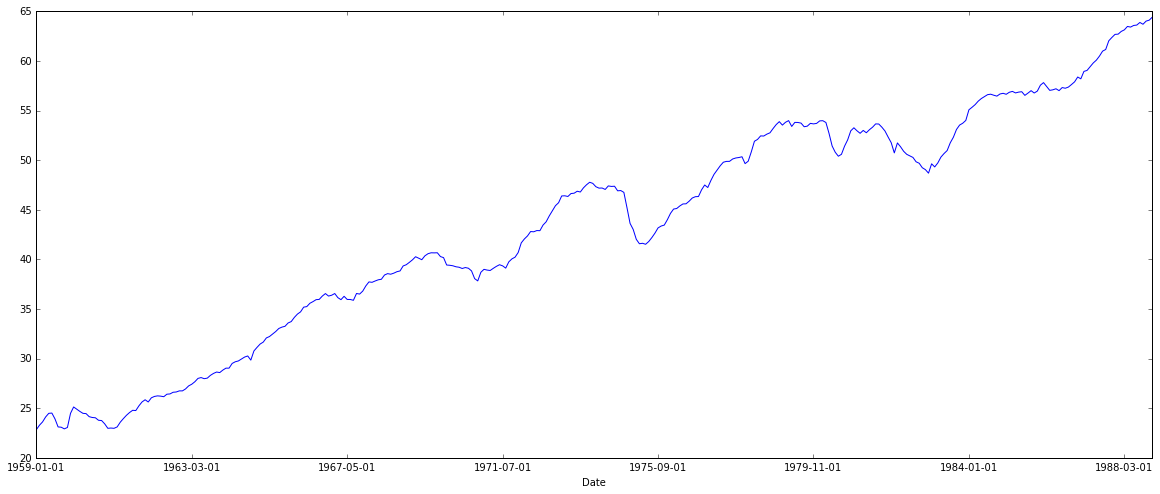

In [330]:
data = pd.read_csv('training.csv')
ts = pd.Series(np.asarray(data['Value'], dtype=np.float), index=data['Date'])
ts.cumsum()
ts.plot(figsize=(20, 8))

## plot moving stats

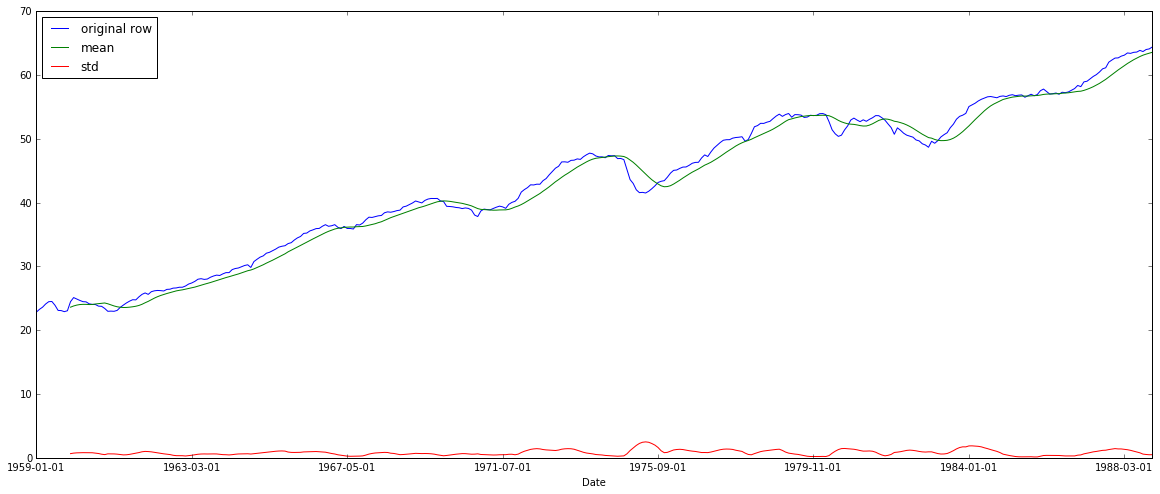

In [246]:
def plotStats(ts):
    ts.plot(color='b', legend=True, figsize=(20, 8), label='original row')
    ts.rolling(window=12,center=False).mean().plot(color='g', legend=True, label='mean')
    ts.rolling(window=12, center=False).std().plot(color='r', legend=True, label = 'std')
    
plotStats(ts)

## DF test

In [247]:
def dfTest(ts, isPrint=True):
    test = sm.tsa.adfuller(ts)
    if isPrint:
        print 'adf: ', test[0] 
        print 'p-value: ', test[1]
        print'Critical values: ', test[4]
    if test[0]> test[4]['5%']: 
        if isPrint:
            print 'have unit roots, a number is not stationary'
        return False
    else:
        if isPrint:
            print 'unit roots there, a number of stationary'
        return True
    return False

dfTest(ts)

adf:  -0.253391179928
p-value:  0.931851042299
Critical values:  {'5%': -2.869739378430086, '1%': -3.4489583388155194, '10%': -2.5711381780459002}
have unit roots, a number is not stationary


False

## decomposition into trend, residue, sezonalnost

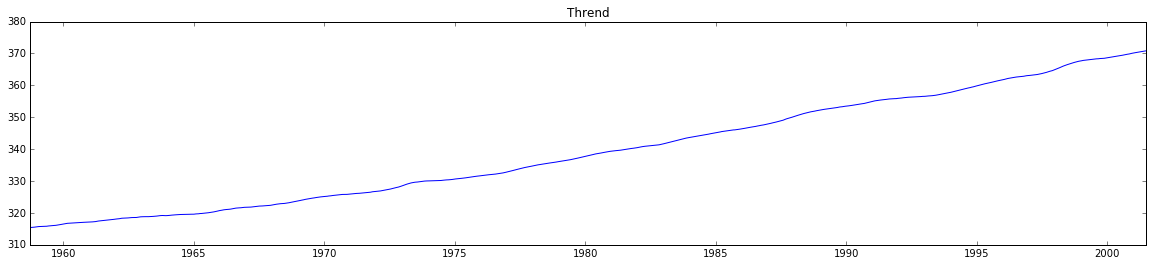

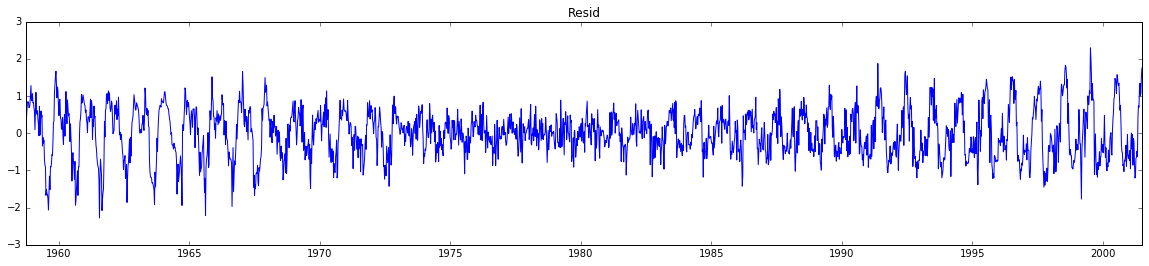

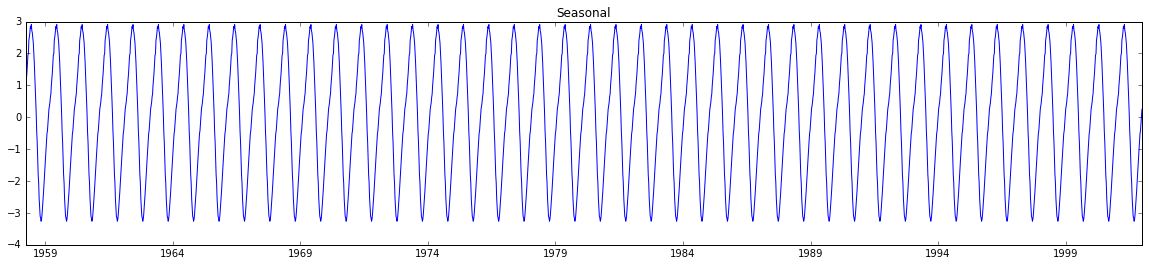

In [248]:
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
decom = seasonal_decompose(data.Value)
def showPlot(x, title=''):
    plt.figure(figsize=(20, 4))
    plt.plot(x)
    plt.title(title)
    plt.show()

trend = decomp.trend
resid = decomp.resid
seasonal = decomp.seasonal

showPlot(trend, 'Thrend')
showPlot(resid, 'Resid')
showPlot(seasonal, 'Seasonal')

## check the trend stationarity

Index([u'co2'], dtype='object')
adf:  2.11167676459
p-value:  0.998801597294
Critical values:  {'5%': -2.8628516682161713, '1%': -3.4333191288144413, '10%': -2.5674682648176428}
have unit roots, a number is not stationary


False

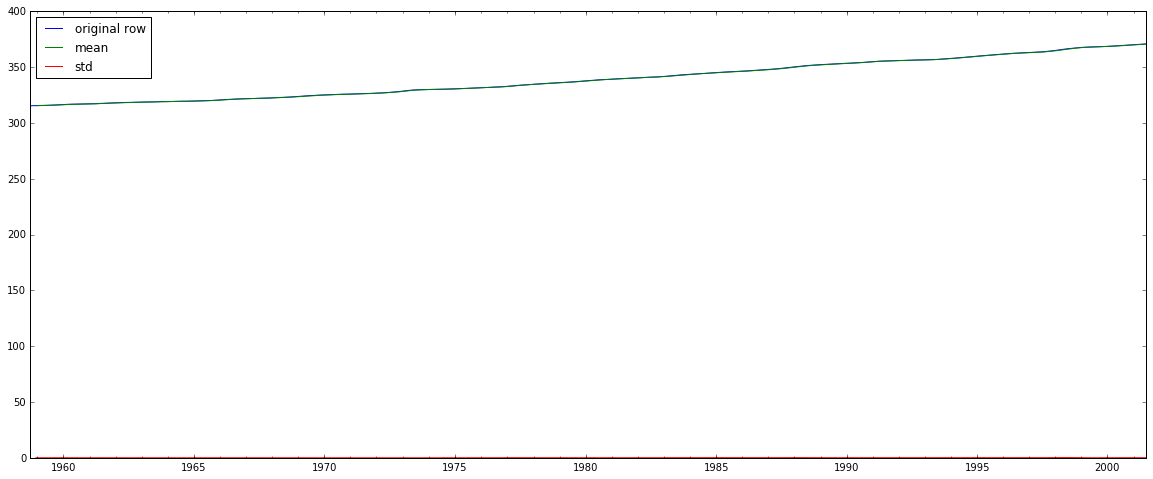

In [249]:
print trend.keys()
trend.dropna(inplace=True)
tsTrend = pd.Series(np.asarray(trend['co2'], dtype=np.float), index=trend.index)
plotStats(tsTrend)
dfTest(tsTrend)

## check the resid stationarity

adf:  -15.7574489293
p-value:  1.2028720073e-28
Critical values:  {'5%': -2.8628522637456255, '1%': -3.4333204775429715, '10%': -2.5674685818969634}
unit roots there, a number of stationary


True

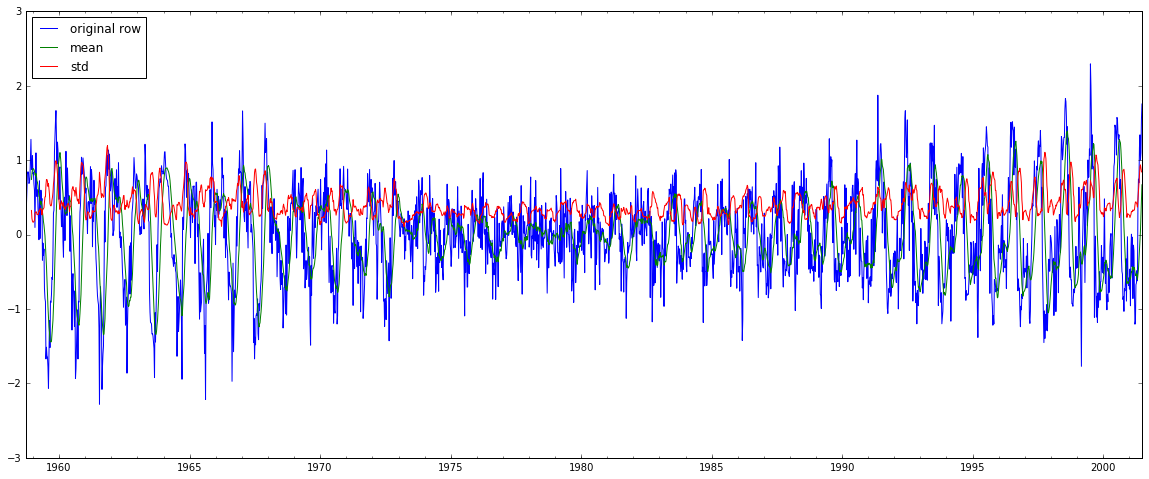

In [250]:
resid.dropna(inplace=True)
tsResid = pd.Series(np.asarray(resid['co2'], dtype=np.float), index=resid.index)
tsResid.cumsum()
plotStats(tsResid)
dfTest(tsResid)

## check the sesonal stationarity

adf:  -28.4197318968
p-value:  0.0
Critical values:  {'5%': -2.8628219967376647, '1%': -3.4332519309441296, '10%': -2.5674524668103338}
unit roots there, a number of stationary


True

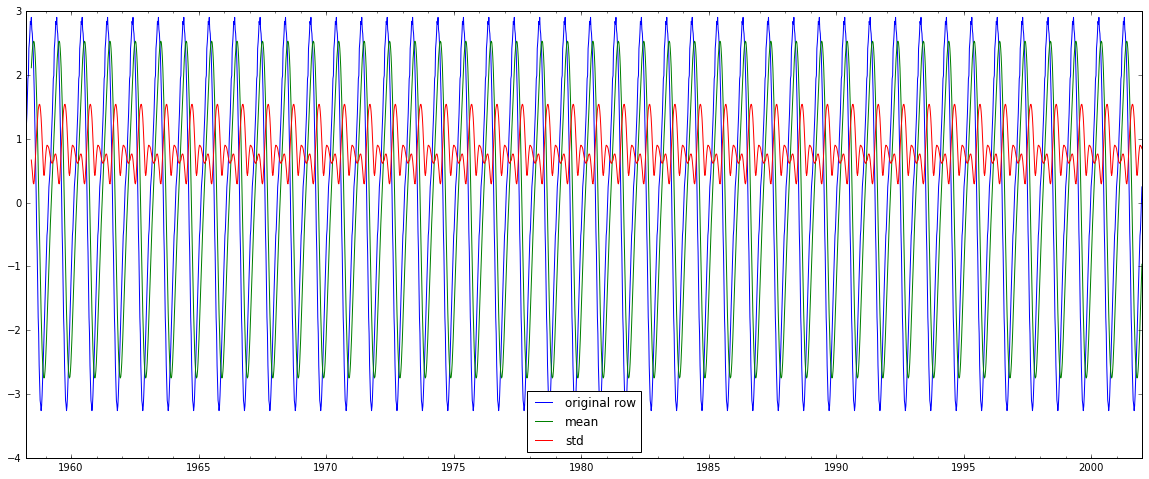

In [251]:
seasonal.dropna(inplace=True)
tsSeasonal = pd.Series(np.asarray(seasonal['co2'], dtype=np.float), index=seasonal.index)
tsSeasonal.cumsum()
plotStats(tsSeasonal)
dfTest(tsSeasonal)

### Conclusion: Using Dickey - Fuller test and graphics, it is that the trend is not stationary, but sezonalnost and resid - stationary

# Find order of integration

In [252]:
def findOrder(ts, isPrint=False):
    integrationOrder = 0
    while not dfTest(ts, isPrint):
        ts = ts.diff(periods=1).dropna()
        integrationOrder += 1
    return integrationOrder

In [256]:
k = findOrder(ts)
print k

1


### Find autocorrelation function parameters

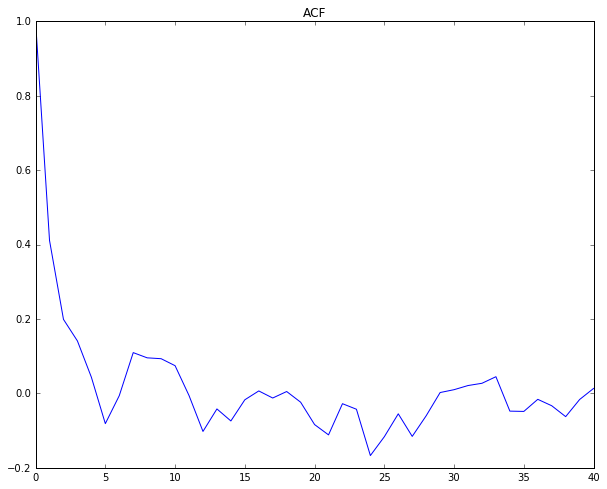

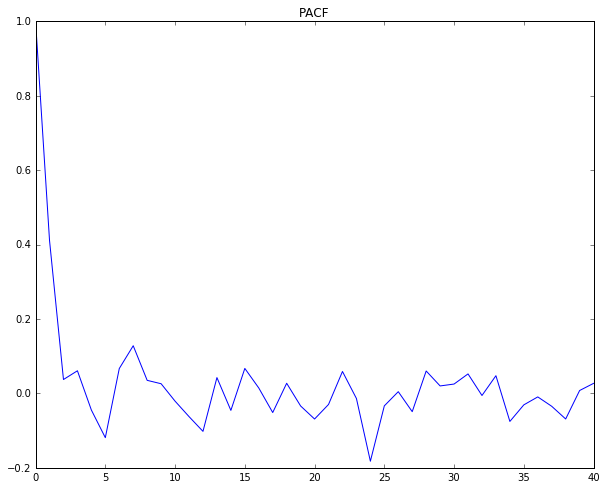

In [291]:
log_shift_ts = (np.log(ts) - np.log(ts).shift())
log_shift_ts.dropna(inplace=True)
acf = acf(log_shift_ts)
pacf = pacf(log_shift_ts, method='ols')
    
    
plt.figure(figsize=(10, 8))    
plt.plot(acf)
plt.title('ACF')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(pacf)
plt.title('PACF')
plt.show()

### Train ARIMA model

R^2 value:  0.170590147887


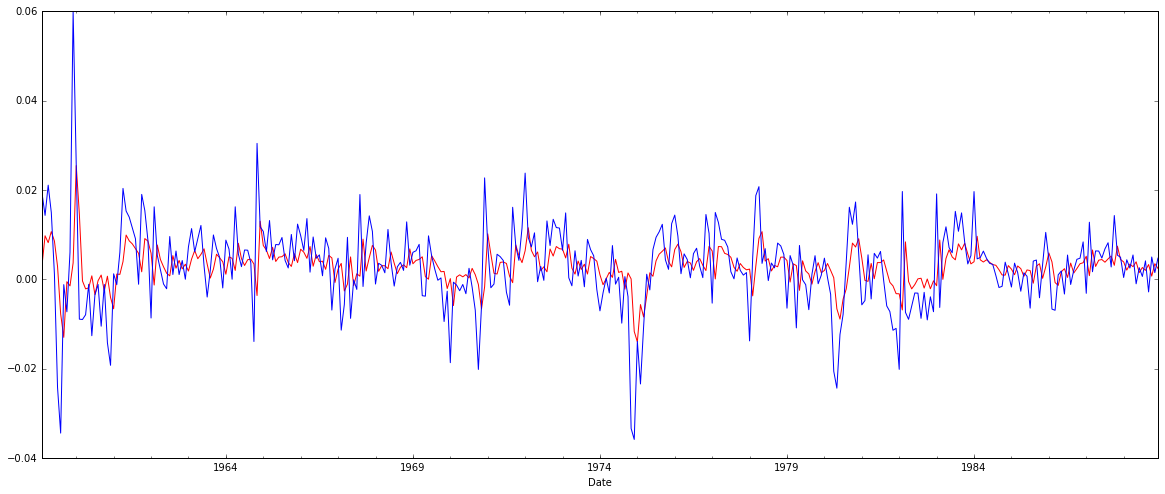

In [356]:
ts.index = pd.to_datetime(ts.index)
ts_log = np.log(ts)
#print ts_log
model = ARIMA(ts_log, order=(int(pacf[0]), k, int(acf[0])))
fit_val = model.fit(disp=-1)
pred = fit_val.fittedvalues

ts_log_diff = (np.log(ts) - np.log(ts).shift())
ts_log_diff.dropna(inplace=True)
pred.plot(figsize=(20, 8), color='r')
ts_log_diff.plot(figsize=(20, 8), color='b')
print 'R^2 value: ', r2_score(ts_log_diff, pred)

### Check on test set

In [429]:
dataTest = pd.read_csv('testing.csv')
tsTest = pd.Series(np.asarray(dataTest['Value'], dtype=np.float), index=dataTest['Date'])
tsTest.cumsum()

predict = fit_val.predict('1988-12-01', '1993-12-01')
predict = predict['1989-01-01':]

R2 Score: -1.9226


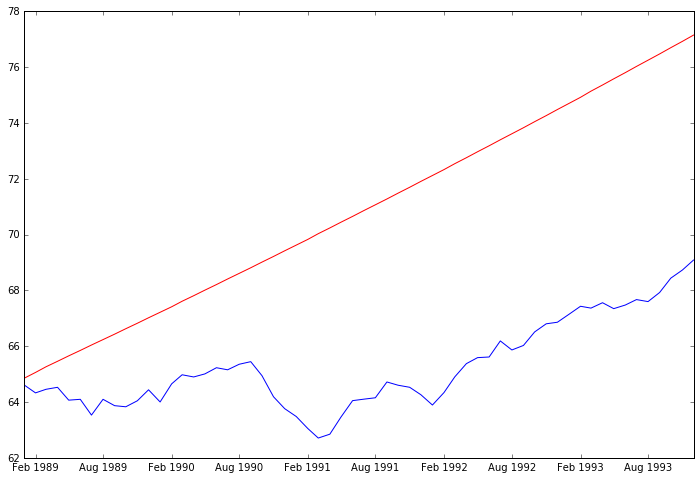

In [430]:
predict[0] += np.log(tsTest[0])
predict = predict.cumsum()
predict = np.exp(predict) 
plt.figure(figsize=(12,8))
plt.plot(predict, color='r')
plt.plot(tsTest, color='b')
print ('R2 Score: %.4f' % r2_score(predict, tsTest))